# Homework 3

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# 1. Modeling Volatility and VaR

## Data

Find the data file `spy_data.xlsx`.

* Use the returns on the S&P 500 (`SPY`) and 1-month T-bills (`^IRX`).

* Calculate the excess market returns, using the treasury rate as the risk-free rate.

***

## 1.1 Historic VaR.
Starting at `Jan 2, 2001`, calculate the historic-based VaR, based on the expanding sample from the first date through `Dec 29, 2000`. 

Denote $\tilde{r}^{VaR, 0.05}_{t}$ as the estimate of the time-t VaR based on data through $t − 1$.

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* Plot $\tilde{r}^{VaR, 0.05}_{t}$ over time.

* Report the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$. Compare this to the quantile of $.05$.

* What drawbacks do you see in this historic VaR?

#### Note
By historic VaR, we mean simply taking the 5th quantile for the historic sample up to time $t − 1$. Of course, a sample size that is not a multiple of 100 will require some interpolation to get a 5th quantile. Your statistical package should handle this fine.

***

## 1.2 Volatility
We will calculate a time-series of volatility estimates using a few different methods. For each, we use $\sigma_t$ to denote our estimate of the time-t return volatility.

#### Expanding Series

$$
\sigma^2_{t,expanding} = \frac{1}{t-1}\sum_{\tau = 1}^{t-1}\tilde{r}^2_{\tau}
$$



#### Rolling Window

$$
\sigma^2_{t,rolling} = \frac{1}{m}\sum_{l = 1}^{m}\tilde{r}^2_{t-l}
$$

Use $m=$`252`.


#### Exponentially Weighted Moving Average (EWMA)

Feel free to calculate the EWMA using the following recursion,
$$
\sigma^2_{t, EWMA} = \theta \sigma^2_{t-1, EWMA} + (1-\theta)\tilde{r}^2_{t-1}
$$

Rather than estimating $\theta$, simply use $\theta$ = 0.94, and initialize with 
$$\sigma_{t_0} = \frac{0.20}{\sqrt{252}}$$

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* For each of these three methods, plot $\sigma_t$. (Plot the vol, not the variance.)

* For each method, calculate the 5th percentile, 1-day-ahead VaR. We use a slight simplification of the normal VaR formula, by dropping $\mu$ from that formula, and rounding the normal distribution z-score to -1.65.
$$\tilde{r}^{VaR, 0.05}_{t} = −1.65 \sigma_t$$

* For each of these vol-based VaR estimates, calculate the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$

* Compare and contrast your results among each other and relative to the historic method in the previous problem.

***

## 1.3 CVaR
Re-do the previous two problems, but this time calculating CVaR instead of VaR, (still for $q =$ `.05`.) 

***

## 1.4 GARCH

#### EXTRA: Not Submitted, not covered in Midterm 1

Re-do the VaR and CVaR calculations using a normal model with volatility calculated from a GARCH(1,1).

To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation implementation is fine. You should be familiar with EWMA and GARCH from the August Review.

In [2]:
# 1 Modeling Volatility and VaR
# Imports
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm

In [5]:
# Data
FILEPATH = '../data/spy_data.xlsx'
data = pd.read_excel(FILEPATH, sheet_name='total returns')
data['date'] = pd.to_datetime(data['date'])
data['Excess Returns'] = data['SPY'] - data['^IRX']
data.set_index('date', inplace = True)
data.head()

,SPY,^IRX,Excess Returns
date,,,
1994-01-04,0.004035,0.000122,0.003913
1994-01-05,0.002009,0.000122,0.001888
1994-01-06,0.000000,0.000121,-0.000121
1994-01-07,0.006016,0.000119,0.005897
1994-01-10,0.011960,0.000119,0.011841


,Historic VaR
date,
1994-01-04,NaN
1994-01-05,0.003913
1994-01-06,0.001989
1994-01-07,0.000080
1994-01-10,0.000180


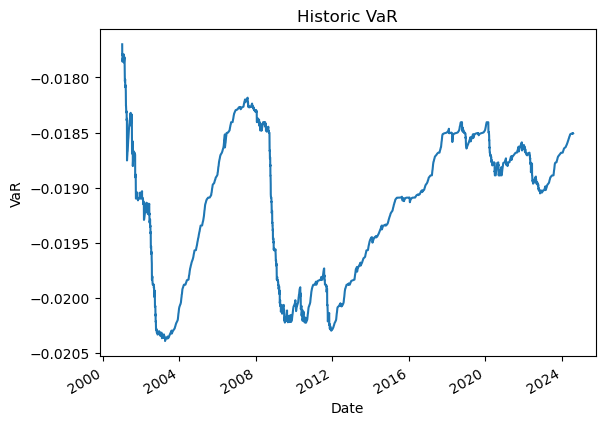

In [7]:
# 1.1 Historic VaR
VaR = pd.DataFrame()
VaR['Historic VaR'] = (data['Excess Returns'].shift().expanding().quantile(.05))
VaR.loc['2001-01-02':]['Historic VaR'].plot(title='Historic VaR', ylabel='VaR', xlabel='Date')
VaR.head()

In [13]:
# Report
violations = (data['Excess Returns'] < VaR['Historic VaR'])
print(violations.head())
violation_frequency = violations.mean()
expected_frequency = 0.05
print(f"Observed frequency of violations: {violation_frequency:.4f}")
print(f"Expected frequency of violations: {expected_frequency:.4f}")

date
1994-01-04    False
1994-01-05     True
1994-01-06     True
1994-01-07    False
1994-01-10    False
dtype: bool
Observed frequency of violations: 0.0577
Expected frequency of violations: 0.0500


#### Drawbacks of Historic VaR
1. Historic Var is based on the assumption that the past returns fully capture the risk and history repeats itself.  This is not always true
2. Histoic VaR ignores volatility clustering. (GARCH)
3. Does not take any distribution into account.
4. It is backward looking and is limited to the amount of historic data available.

            Expanding Series  Rolling Window      EWMA
date                                                  
2001-01-02          0.011099        0.015037  0.016979
2001-01-03          0.011104        0.015068  0.017063
2001-01-04          0.011160        0.015165  0.020270
2001-01-05          0.011160        0.015180  0.019835
2001-01-08          0.011184        0.015286  0.020846


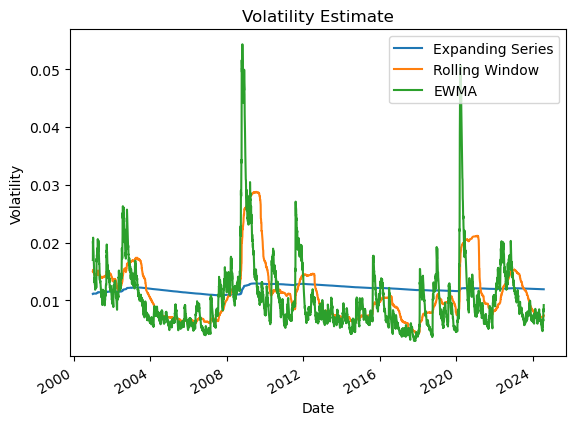

In [18]:
# 1.2 Volatility
# Report
expanding_series = np.sqrt((data['Excess Returns']**2).expanding().mean().shift())

rolling_window = np.sqrt((data['Excess Returns']**2).rolling(252).mean().shift())

theta = 0.94 
ewma = np.zeros(len(data))
ewma[0] = 0.20 / np.sqrt(252)
for t in range(1, len(data)):
    ewma[t] = np.sqrt(theta * ewma[t-1]**2 + (1 - theta) * data['Excess Returns'].iloc[t-1]**2)


volatility = pd.DataFrame({
    'Expanding Series': expanding_series,
    'Rolling Window': rolling_window,
    'EWMA': ewma}, index=data.index)

print(volatility.loc['2001-01-02':].head())
volatility.loc['2001-01-02':].plot(title='Volatility Estimate', ylabel='Volatility', xlabel='Date')
plt.show()

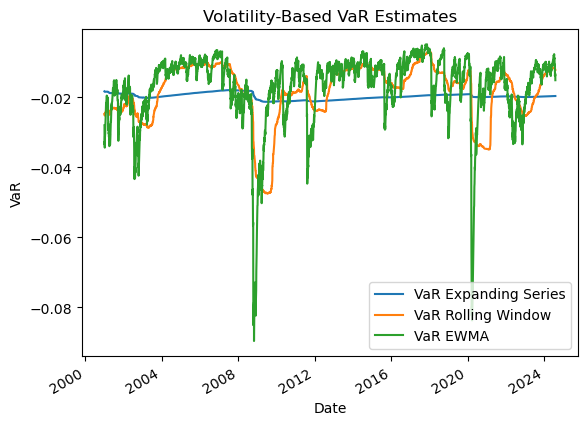

In [22]:
z_score = -1.65
VaR_volatility = pd.DataFrame({
    'VaR Expanding Series': z_score * volatility['Expanding Series'],
    'VaR Rolling Window': z_score * volatility['Rolling Window'],
    'VaR EWMA': z_score * volatility['EWMA']}, index=volatility.index)

VaR_volatility.loc['2001-01-02':].plot(title='Volatility-Based VaR Estimates', ylabel='VaR', xlabel='Date')
plt.show()

In [26]:
excess_returns = data['Excess Returns']

violations_expanding = excess_returns < VaR_volatility['VaR Expanding Series']
violations_rolling = excess_returns < VaR_volatility['VaR Rolling Window']
violations_ewma = excess_returns < VaR_volatility['VaR EWMA']

freq_expanding = violations_expanding.mean()
freq_rolling = violations_rolling.mean()
freq_ewma = violations_ewma.mean()

print(f"Observed frequency of violations Volatility (Expanding): {freq_expanding:.4f}")
print(f"Observed frequency of violations Volatility (Rolling): {freq_rolling:.4f}")
print(f"Observed frequency of violations Volatility (EWMA): {freq_ewma:.4f}")
print(f"Observed frequency of violations Excess Returns (Historic: {violation_frequency:.4f}")

Observed frequency of violations Volatility (Expanding): 0.0530
Observed frequency of violations Volatility (Rolling): 0.0512
Observed frequency of violations Volatility (EWMA): 0.0581
Observed frequency of violations Excess Returns (Historic: 0.0577


1. The EWMA and Historic Returns VaR methods have very similar violation frequencies (0.0581 and 0.0577) and exceed 5% => Sensitive to changes in volatility.
2. The Expanding and Rolling methods are closer to 5% but may not react as quickly and effectively to rapid volatility changes,=> less sensitive to changes in volaitlity than EWMA and Historic VaR.

/var/folders/zq/2lldft9s0d9cwsl0tb1nf59h0000gn/T/ipykernel_9297/3072275331.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  below_var = data['Excess Returns'].iloc[:t][data['Excess Returns'].iloc[:t] < VaR_volatility['VaR EWMA'][t]]


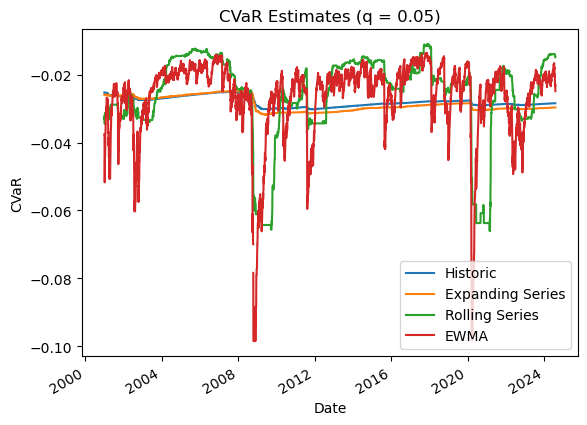

            Historic  Expanding Series  Rolling Series      EWMA
date                                                            
2001-01-02 -0.025234         -0.025849       -0.032980 -0.037553
2001-01-03 -0.025234         -0.025849       -0.032075 -0.037553
2001-01-04 -0.025234         -0.025943       -0.032075 -0.051710
2001-01-05 -0.025404         -0.026029       -0.032171 -0.051710
2001-01-08 -0.025404         -0.026029       -0.034510 -0.051710


In [36]:
CVaR = pd.DataFrame()
CVaR['Historic'] = data['Excess Returns'].expanding().apply(lambda x: x[x < x.quantile(0.05)].mean())

CVaR['Expanding Series'] = data['Excess Returns'].expanding().apply(lambda x: x[x < VaR_volatility['VaR Expanding Series'].loc[x.index[-1]]].mean())
CVaR['Rolling Series'] = data['Excess Returns'].rolling(252).apply(lambda x: x[x < VaR_volatility['VaR Rolling Window'].loc[x.index[-1]]].mean())
ewma_cvar = [np.nan]
for t in range(1, len(data)):
    below_var = data['Excess Returns'].iloc[:t][data['Excess Returns'].iloc[:t] < VaR_volatility['VaR EWMA'][t]]
    ewma_cvar.append(below_var.mean() if not below_var.empty else np.nan)
CVaR['EWMA'] = pd.Series(ewma_cvar, index=data.index)

CVaR.loc['2001-01-02':].plot(title='CVaR Estimates (q = 0.05)', ylabel='CVaR', xlabel='Date')
plt.show()
print(CVaR.loc['2001-01-02':].head())

In [18]:
# EXTRA: 1.4 GARCH
from arch import arch_model

GARCH = arch_model(data['Excess Returns'], vol='Garch', p=1, o=0, q=1, dist='Normal')
GARCH_model = GARCH.fit()
GARCH_params = GARCH_model.params

Iteration:      1,   Func. Count:      6,   Neg. LLF: 478102230897.0185
Iteration:      2,   Func. Count:     19,   Neg. LLF: -24835.203768542277
Optimization terminated successfully    (Exit mode 0)
            Current function value: -24835.203801495925
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001418. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [26]:
theta = 0.97
sigma1 = 0.15

avail_dates = vol.dropna().index

garch = pd.Series(0, index=avail_dates, name='GARCH')
garch[0] = sigma1

ewma[0] = sigma1

for i, ind in enumerate(avail_dates[1:], 1):
    garch[i] = np.sqrt(GARCH_params['omega'] \
        + garch[i-1]**2 * GARCH_params['beta[1]'] \
            + data['Excess Returns'].loc[ind]**2 * GARCH_params['alpha[1]'])
    ewma[i] = np.sqrt(ewma[i-1]**2 * theta + (1-theta) * data['Excess Returns'].loc[ind]**2)

vol = pd.concat([vol, garch, ewma], axis=1)
vol.dropna()

/var/folders/xn/yvr9rshj6v3g5211vsnmlqqr0000gn/T/ipykernel_93534/1274784943.py:7: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  garch[0] = sigma1
/var/folders/xn/yvr9rshj6v3g5211vsnmlqqr0000gn/T/ipykernel_93534/1274784943.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.15' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  garch[0] = sigma1
/var/folders/xn/yvr9rshj6v3g5211vsnmlqqr0000gn/T/ipykernel_93534/1274784943.py:9: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ewma[0] = sigma1

,expanding_series,rolling_window,ewma,GARCH,Excess Returns
date,,,,,
1995-01-06,0.006731,0.006731,0.006784,0.150000,0.006984
1995-01-09,0.006718,0.006727,0.006763,0.140723,0.007508
1995-01-10,0.006705,0.006726,0.006742,0.132021,0.007746
1995-01-11,0.006692,0.006726,0.006721,0.123858,0.007695
1995-01-12,0.006679,0.006716,0.006701,0.116201,0.007585
...,...,...,...,...,...
2024-07-29,0.011912,0.007293,0.009261,0.009873,0.009261
2024-07-30,0.011911,0.007280,0.009243,0.009560,0.009243
2024-07-31,0.011911,0.007263,0.009230,0.010441,0.009230


<Axes: title={'center': 'VaR Estimates'}, xlabel='Date', ylabel='5% VaR'>

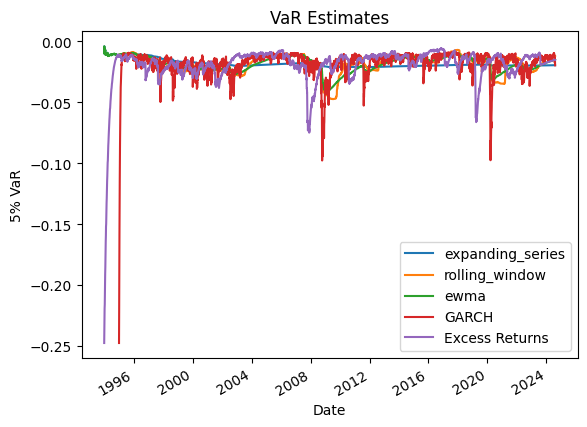

In [27]:
VaR = -1.65*vol

VaR.plot(title = 'VaR Estimates', ylabel = '5% VaR', xlabel = 'Date')

In [28]:
var_temp = VaR.dropna()
frequency = VaR_temp.apply(lambda x: data['Excess Returns'][var_temp.index] < x).mean(numeric_only=True).to_frame('frequency')
frequency.style.format('{:,.2%}')

,frequency
expanding_series,5.29%
rolling_window,5.29%
ewma,4.70%
